In [1]:
import numpy as np
import torch
from torch import nn
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle
from deepmusic import MusicRepr, Constants
from importlib import reload

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

seed_everything(42)

/home/soroosh/projects/general_env/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(
Global seed set to 42


42

## data

In [2]:
const = Constants(unit=4, num_tempo_bins=20, num_velocity_bins=20)
train_files = pickle.load(open('assets/train_files.pkl', 'rb'))
test_files = pickle.load(open('assets/test_files.pkl', 'rb'))
val_files = pickle.load(open('assets/val_files.pkl', 'rb'))

data_config = {
    'data_dir' : '/home/soroosh/data/MIDI/LMD-Matched/lmd_processed/',
    'const' : const,
    'instruments' : ['piano', 'drums', 'guitar', 'bass', 'ensemble'],
    'max_files' : 1200,
    'window_len' : 5,
    'max_len' : 720,
    'pad_value' : 0,
    'mask_prob' : 0.2,
    'n_jobs' : 20
}

In [9]:
import src.data.multi
reload(src.data.multi)

import src.data
reload(src.data)

from src.data import MultiTrackDataset, get_dataloader

train_dataset = MultiTrackDataset(**data_config, files=train_files)
test_dataset = MultiTrackDataset(**data_config, files=test_files)
val_dataset = MultiTrackDataset(**data_config, files=val_files)

In [10]:
sample = train_dataset[0]
for inst in sample:
    print(inst, len(sample[inst]))

piano 190
drums 150
guitar 65
bass 65
ensemble 109


In [11]:
tl = get_dataloader(train_dataset, batch_size=2, n_jobs=2)
vl = get_dataloader(val_dataset, batch_size=2, n_jobs=2)

In [12]:
b = next(iter(tl))
for inst in b:
    print(inst)
    for k in b[inst]:
        print('   ', k, b[inst][k].shape)

piano
    X torch.Size([2, 233])
    X_len torch.Size([2])
    labels torch.Size([2, 233])
drums
    X torch.Size([2, 183])
    X_len torch.Size([2])
    labels torch.Size([2, 183])
guitar
    X torch.Size([2, 89])
    X_len torch.Size([2])
    labels torch.Size([2, 89])
bass
    X torch.Size([2, 84])
    X_len torch.Size([2])
    labels torch.Size([2, 84])
ensemble
    X torch.Size([2, 151])
    X_len torch.Size([2])
    labels torch.Size([2, 151])


## model

In [13]:
d_model = 256
n_vocab = len(const.all_tokens)
dropout = 0.1
instruments = ['drums', 'ensemble', 'bass']
memory_streams = ['piano', 'drums', 'guitar', 'ensemble', 'bass']

model_config = {
    'lr' : 1e-4,
    'max_epochs' : 20,
    'instruments' : instruments,
    'const' : const,
    'tasks' : ['s2s'],
    'embedding': {
        'd_model' : d_model,
        'n_vocab' : n_vocab,
        'd_tok_emb' : 256,
        'dropout' : dropout,
        
        'positional_embedding' : 'note',
        'd_pos_emb' : 32,
        'const' : const,
        'max_bar' : 5,
        'concat_pos' : True,
#         'max_len' : 10000,
        
        'style_classes' : 0,
        'd_style_emb' : 0
    },
    'encoder' : {
        'd_model' : d_model,
        'n_head' : 8,
        'd_inner' : 512,
        'dropout' : dropout,
        'n_layer' : 4
    },
    'decoder' : {
        'memory_streams' : memory_streams,
        'd_model' : d_model,
        'n_head' : 8,
        'd_inner' : 512,
        'dropout' : dropout,
        'n_layer' : 4
    },
    'head' : {
        'd_model' : d_model,
        'n_vocab' : n_vocab
    }
}

In [14]:
import src.models.multi_memory_enc_dec
reload(src.models.multi_memory_enc_dec)
from src.models.multi_memory_enc_dec import EncoderMultiMemoryDecoderPerformer
from src import Experiment

model = EncoderMultiMemoryDecoderPerformer(model_config)

# exp = Experiment(root_dir='exps/', name='exp_4')
# model = EncoderMultiMemoryDecoderPerformer.load_from_checkpoint(exp.weights_path + 'last.ckpt', config=model_config)

model.count_parameters()

training tasks: s2s


9917373

In [15]:
logits, loss = model(task='s2s', trg_inst='drums', inputs=b)
loss

tensor(5.9757, grad_fn=<DivBackward0>)

## train

In [16]:
exp = Experiment(
    root_dir='exps/', 
    data_conf=data_config, 
    model_conf=model_config
)
exp.save_path

'exps/exp_1/'

In [17]:
logger = TensorBoardLogger(save_dir=exp.save_path, name='logs/')
lr_logger = LearningRateMonitor(logging_interval='step')
checkpoint = ModelCheckpoint(
    dirpath=exp.weights_path, 
    filename='{epoch}-{val_loss:.2f}', 
    monitor='train_loss',
    save_top_k=10, 
    period=1
)

trainer = Trainer(
    benchmark=True, 
    gpus=1, 
    accumulate_grad_batches=8,
    logger=logger, 
    max_epochs=model_config['max_epochs'],
    callbacks=[checkpoint, lr_logger]
)

/home/soroosh/projects/general_env/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:396: LightningDeprecationWarning: Argument `period` in `ModelCheckpoint` is deprecated in v1.3 and will be removed in v1.5. Please use `every_n_val_epochs` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(model, tl, vl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                          | Params
------------------------------------------------------------
0 | criterion | CrossEntropyLoss              | 0     
1 | embedding | RemiEmbedding                 | 164 K 
2 | encoder   | TransformerEncoder            | 2.1 M 
3 | decoder   | TransformerMultiMemoryDecoder | 7.4 M 
4 | heads     | ModuleDict                    | 270 K 
------------------------------------------------------------
9.9 M     Trainable params
0         Non-trainable params
9.9 M     Total params
39.669    Total estimated model params size (MB)


Global seed set to 42


In [18]:
trainer.save_checkpoint(f'{exp.weights_path}/last.ckpt')

## generate

In [5]:
from src import Experiment

exp = Experiment(root_dir='exps/', name='exp_0')

In [165]:
import src.models.multi_memory_enc_dec
reload(src.models.multi_memory_enc_dec)
from src.models.multi_memory_enc_dec import EncoderMultiMemoryDecoderPerformer

gen_model = EncoderMultiMemoryDecoderPerformer.load_from_checkpoint(f"{exp.weights_path}/last.ckpt", config=model_config)

training tasks: s2s


In [166]:
def evaluate_file(file):
    seq = MusicRepr.from_file(data_config['data_dir'] + file, const=const).keep_instruments(['piano','drums', 'guitar', 'bass','ensemble'])
    save_path = f'{exp.assets_path}{file[:-4]}/'
    os.makedirs(save_path, exist_ok=True)
    seq.to_midi(save_path + f'original.mid')
    for inst in ['bass','drums','ensemble']:
        generate_track(seq, inst, save_path, n_bar=5, start_idx=0)
        break


def generate_track(seq, trg_inst, save_path, n_bar=50, start_idx=0):
    prompt = MusicRepr.concatenate(seq.get_bars()[start_idx:start_idx+n_bar]).remove_instruments([trg_inst])
    print('generating',trg_inst, '...')
    
    res = gen_model.generate(trg_inst, seq=prompt, window=5, top_p=1., t=1.)
    print(res)
    gen_seq = MusicRepr.from_string(res, const=const)
    
    tracks = prompt.separate_tracks()
    tracks[trg_inst] = gen_seq
    final_seq = MusicRepr.merge_tracks(tracks)
    
    final_seq.to_midi(save_path + f'{trg_inst}_merge.mid')
    gen_seq.to_midi(save_path + f'{trg_inst}_gen.mid')
    prompt.to_midi(save_path + f'{trg_inst}_prompt.mid')
    print(f'\r{trg_inst} generation results are saved in', save_path)

    plt.figure(figsize=(20,5))
    plt.title(trg_inst)
    plt.imshow(gen_seq.to_pianoroll(add_tempo_chord=False)[trg_inst])
    plt.savefig(save_path + f'{trg_inst}.png')

generating bass ...



['Bar', 'BeatTempo_115', 'BeatPosition_10', 'NoteInstFamily_bass', 'NotePitch_46', 'NoteDuration_1', 'NoteVelocity_113', 'BeatPosition_14', 'NoteInstFamily_bass', 'NotePitch_39', 'NoteDuration_1', 'NoteVelocity_113', 'Bar', 'BeatChord_C_M7', 'Bar', 'BeatChord_C_M7', 'NoteInstFamily_bass', 'NotePitch_36', 'NoteDuration_4', 'NoteVelocity_87', 'BeatPosition_5', 'NoteInstFamily_bass', 'NotePitch_36', 'NoteDuration_1', 'NoteVelocity_87', 'BeatPosition_8', 'BeatChord_C_sus2', 'BeatPosition_9', 'NoteInstFamily_bass', 'NotePitch_36', 'NoteDuration_1', 'NoteVelocity_87', 'BeatPosition_13', 'NoteInstFamily_bass', 'NotePitch_36', 'NoteDuration_1', 'NoteVelocity_80', 'BeatPosition_15', 'NoteInstFamily_bass', 'NotePitch_36', 'NoteDuration_6', 'NoteVelocity_73', 'Bar', 'BeatChord_A_m7', 'Bar', 'BeatChord_A_m7', 'NoteInstFamily_bass', 'NotePitch_33', 'NoteDuration_6', 'NoteVelocity_120', 'BeatPosition_5', 'NoteInstFamily_bass', 'NotePitch_31', 'NoteDuration_10', 'NoteVelocity_113', 'BeatPosition_8',

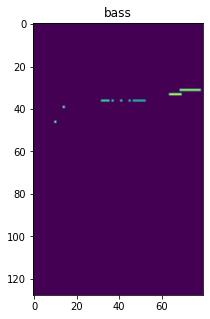

In [167]:
evaluate_file(test_files[0])

In [ ]:
for file in tqdm(te):
    evaluate_file(file)

In [ ]:
# !zip -r exps/exp_4/assets.zip exps/exp_4/assets